## Parte 3
## Rede neural auto-associativa
## (Autoencoder)

Modelo não supervisionado para aprendizado de características. Para estudar esse modelo utilizaremos o problema da reconstrução de imagens.

O espaço latente criado como resultado do treinamento pode ser utilizado como representação compacta dos dados, por exemplo para alimentar classificadores não-Deep Learning.

Serão utilizadas as bibliotecas Tensorflow e Keras

#### Moacir A. Ponti / 2018

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
#from keras.datasets import fashion_mnist

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

Using TensorFlow backend.


Importamos as bibliotecas necessárias. A primeira linha é para melhorar a compatibilidade entre python2 e python3. Depois importamos:
- a biblioteca tensorflow, a matplotlib para gerar gráficos 
- a biblioteca numpy com muitas funcoes para processamento vetorial
- a biblioteca keras, sendo importados pacotes com os dados que serão utilizados nesse notebook

### Base de dados

A seguir iremos carregar efetivamente os dados de treinamento e de testes, cada qual dividido nos dados de entrada $x$ (nesse caso imagens) sem os rótulos pois os auto-encoders são não-supervisionados

Comente e descomente as linhas conforme a base de dados

In [2]:
# carrega as imagens e rotulos de treinamento e teste, separando em 4 matrizes
(x_train,_), (x_test,_) = mnist.load_data()
#(x_train, ), (x_test, ) = fashion_mnist.load_data()


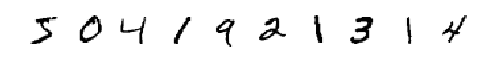

In [3]:
# visualizando algumas imagens de treinamento
n_imgs = 10
for im in np.arange(n_imgs):
  plt.subplot(1,n_imgs,im+1)
  plt.imshow(x_train[im])
  plt.axis('off')

Agora iremos preprocessar a base de dados, capturando seu tamanho e reescalando os valores para o intervalo 0-1

Além disso a base de dados é reformatada - capturamos o formato pelo pacote "K" de forma a adequar se a imagem é armazenada no formato (linhas x colunas x canais) ou (canais x linhas x colunas)

In [4]:
# capturando o tamanho das imagens da base de dados por meio do 'shape' 
# dos arrays carregados
img_rows, img_cols = x_train.shape[1], x_train.shape[2]

# re-formatando as imagens de forma que sejam transformadas em um vetor
# as imagens 28x28 se tornam vetores de 784x1
# o conjunto de treinamento possui 60000 imagens e o de teste 10000 imagens
x_train = x_train.reshape(len(x_train), img_rows*img_cols)
x_test = x_test.reshape(len(x_test), img_rows*img_cols)

In [5]:
# os pixels das imagens sao reescalados para melhor processamento
# em particular divide-se por 255 para que os valores fiquem entre 0 e 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
print('Dataset size:')
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('Data size %d x %d' % (img_rows, img_cols))

Dataset size:
60000 train samples
10000 test samples
Data size 28 x 28


### Configuração do modelo 



In [6]:
input_img = Input(shape=(img_rows*img_cols,))

# encoder
code = Dense(128, activation='relu')(input_img)
code = Dense(32, activation='relu')(code)

# decoder
x_hat = Dense(128, activation='relu')(code)
x_hat = Dense(784, activation='sigmoid')(x_hat)

autoencoder = Model(input_img, x_hat)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_4 (Dense)              (None, 784)               101136    
Total params: 209,968
Trainable params: 209,968
Non-trainable params: 0
_________________________________________________________________


Note como o modelo com camadas convolucionais possui menos parâmetros - esse fato foi um dos motivos de se aumentar a quantidade de camadas convolucionais permitindo a convergência do modelo.

### Compilação e treinamento do modelo
Agora iremos compilar o modelo, definindo:
- A função de custo: utilizamos a entropia cruzada categórica, ou seja, que utiliza rótulos
- O método de otimização:  utilizamos um método baseado no gradiente descendente (Adam) e definimos seus parâmetros como a taxa de aprendizado (*learning rate*) e *momentum*


In [9]:
autoencoder.compile(loss='binary_crossentropy', 
                    optimizer='adadelta')


Finalmente, treinamos o método pela função *fit*, que ajusta os parâmetros aos dados rotulados x_train, y_train e utilizando as configurações de:
- tamanho do *minibatch*, ou seja a quantidade de imagens a serem carregadas em cada iteracao do algoritmo de treinamento da rede neural
- número de épocas: em uma *época/epoch* o algoritmo utiliza todas as imagens do conjunto de treinamento (por exemplo, para a MNIST significa carregar 60 mil imagens e utilizá-las para treinar a rede)


Também informamos quais são os dados de validação. A opção *verbose* exibe os detalhes do processo de treinamento na tela

In [12]:
# tamanho do batch por iteracao
batch_size = 64

# número de épocas 
epochs = 8

# a variável history guarda os dados do processo de treinamento para
# posteriormente analisarmos
history = autoencoder.fit(x_train, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    shuffle=True,
                    verbose=1,
                    validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/8
60000/60000 [==============================] - 11s 186us/step - loss: 0.1156 - val_loss: 0.1220
Epoch 2/8
60000/60000 [==============================] - 11s 187us/step - loss: 0.1140 - val_loss: 0.1152
Epoch 3/8
26432/60000 [============>.................] - ETA: 5s - loss: 0.1123

60000/60000 [==============================] - 11s 186us/step - loss: 0.1120 - val_loss: 0.1088
Epoch 4/8
60000/60000 [==============================] - 11s 186us/step - loss: 0.1104 - val_loss: 0.1069
Epoch 5/8
60000/60000 [==============================] - 11s 184us/step - loss: 0.1088 - val_loss: 0.1099
Epoch 6/8
 2880/60000 [>.............................] - ETA: 10s - loss: 0.1087

60000/60000 [==============================] - 11s 183us/step - loss: 0.1076 - val_loss: 0.1111
Epoch 7/8
60000/60000 [==============================] - 11s 185us/step - loss: 0.1065 - val_loss: 0.1064
Epoch 8/8
59392/60000 [============================>.] - ETA: 0s - loss: 0.1057

60000/60000 [==============================] - 11s 185us/step - loss: 0.1057 - val_loss: 0.1085


### Avaliação do modelo
Com o modelo já treinado, podemos agora avaliar o seu desempenho, tanto no conjunto de treinamento quanto no conjunto de testes

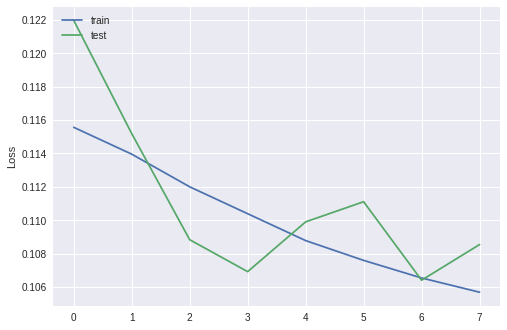

In [13]:
# utilizando o histórico: o gráfico da função de custo ao longo das épocas
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Agora podemos também classificar todos os exemplos de teste e visualizar os resultados de acordo com os rótulos

In [15]:
# obtem as predicoes
decoded_imgs = autoencoder.predict(x_test)

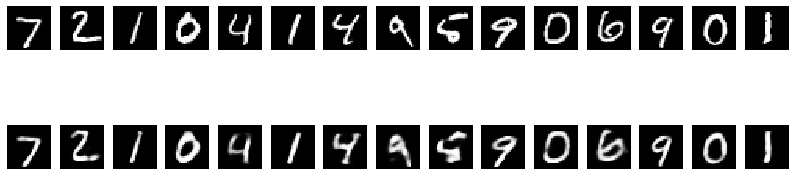

In [16]:
n=15
plt.figure(figsize=(14, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()    

## Exercícios:


1.   Modifique a arquitetura do Autoencoder, reduzindo e adicionando camadas
2.   Adicione uma camada convolucional no encoder e no decoder
3.  Crie um *denoising* autoencoder, inserindo ruído na imagem antes da entrada e criando uma função de custo para comparar a imagem reconstruída com a imagem não ruidosa de entrada - para isso você deverá pesquisar mais sobre implementação de funções de custo no Keras

